In [2]:
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
import re

In [3]:
df = pd.read_csv("/Users/emilyzou/Desktop/pol/deimentionposts.csv")

In [4]:
# split by sentences? 
nlp = spacy.load("en_core_web_sm", disable = ["ner", "tagger"])
def detect_sentences_spacy_pipe(text): 
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

df['S-Text'] = df['Text'].apply(detect_sentences_spacy_pipe)

/Users/emilyzou/opt/miniconda3/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [6]:
def filter_sentences(df, text_column, keyword):
    keyword = keyword.lower()
    filtered_sentences = []
    for _, row in df.iterrows():
        for sentence in row[text_column]:
            if keyword in sentence.lower():
                filtered_sentences.append({**row.drop(text_column).to_dict(), text_column: sentence})
    return pd.DataFrame(filtered_sentences)

In [7]:
da = filter_sentences(df, 'S-Text', "dei")

In [10]:
contractions = {"won't": "wont", "can't": "cant", "n't": "nt", "'re": "re", "'s": "s", "'ll": "ll", "'d": "d", "'ve": "ve", "'m": "m"}

def normalize_contractions(text):
    return re.sub(
        r'\b(' + '|'.join(re.escape(k) for k in contractions.keys()) + r')\b',
        lambda m: contractions[m.group(0).lower()],
        text
    )

def tokenize_and_clean(text):
    if not isinstance(text, str) or pd.isna(text):
        return []
    doc = nlp(text)
    return [token.text for token in doc if token.text.isalnum()]

def process_text_to_tokens(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    text = text.replace("\\n", " ").strip().lower()
    text = normalize_contractions(text)
    tokens = tokenize_and_clean(text)
    return " ".join(tokens)

In [17]:
da['T-Text'] = da['Text'].apply(process_text_to_tokens)

KeyboardInterrupt: 

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [14]:
def get_word_embedding(sentence, target_word):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    token_embeddings = outputs.last_hidden_state
    word_tokens = [i for i, token in enumerate(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])) if token == target_word]
    word_embedding = torch.mean(token_embeddings[0, word_tokens, :], dim=0).detach().numpy()
    return word_embedding

In [15]:
def process_dataframe_with_embeddings(df, text_column, target_word, preserve_columns):
    processed_data = []
    for _, row in df.iterrows():
        sentence = row[text_column]
        embedding = get_word_embedding(sentence, target_word)
        processed_row = {col: row[col] for col in preserve_columns}
        processed_row["Embedding"] = embedding
        processed_data.append(processed_row)
    return pd.DataFrame(processed_data)

In [17]:
preserve_columns = ["id", "Date", "Thread No"]

In [18]:
embeddf = process_dataframe_with_embeddings(df, "T-Text", "dei", preserve_columns)

In [26]:
em = em[em["Embedding"].apply(lambda x: isinstance(x, np.ndarray) and not np.isnan(x).any())]


In [28]:
em.to_csv("11_19_dei_contextualembeddings.csv")

In [24]:
import numpy as np

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_18609/646420673.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em["Dim1"] = reduced_embeddings[:, 0]
/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_18609/646420673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

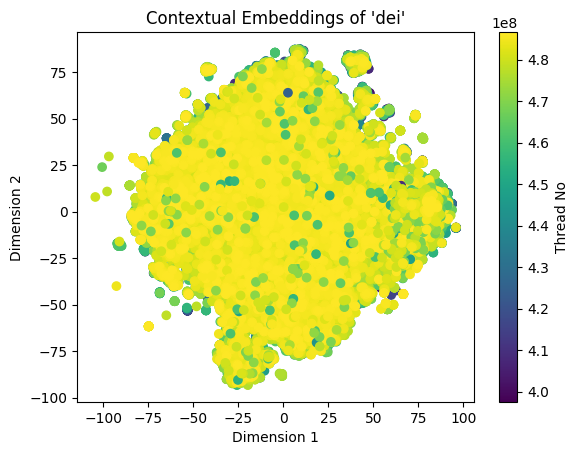

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings = np.vstack(em["Embedding"].values)
reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Add reduced dimensions to the DataFrame
em["Dim1"] = reduced_embeddings[:, 0]
em["Dim2"] = reduced_embeddings[:, 1]

# Visualize
plt.scatter(em["Dim1"], em["Dim2"], c=em["Thread No"], cmap='viridis')
plt.colorbar(label="Thread No")
plt.title("Contextual Embeddings of 'dei'")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

/Users/emilyzou/opt/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/b9/j4cr1qk10pgfhhshk13f4zgm0000gn/T/ipykernel_18609/1461894396.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  em["Cluster"] = kmeans.fit_predict(embeddings)


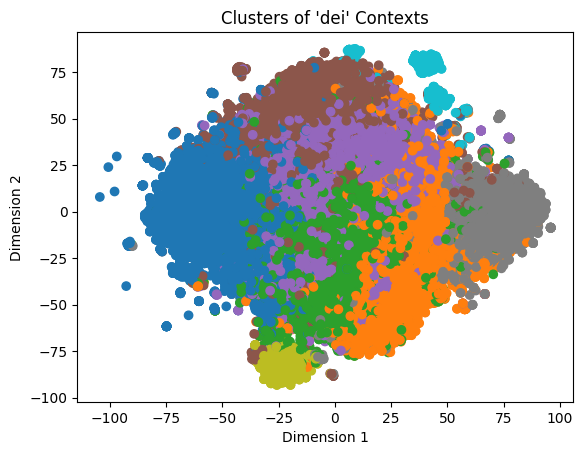

In [32]:
from sklearn.cluster import KMeans
num_clusters = 8
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
em["Cluster"] = kmeans.fit_predict(embeddings)



plt.scatter(em["Dim1"], em["Dim2"], c=em["Cluster"], cmap='tab10')
plt.title("Clusters of 'dei' Contexts")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [33]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
silhouette_avg = silhouette_score(embeddings, em['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.06064993143081665


In [ ]:
from sklearn.cluster import KMeans

# Example with K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(embeddings)
print(f"Sum of Squared Distances: {kmeans.inertia_}")

In [1]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Example: Find the most similar usage of 'dei' for the first sentence
most_similar_idx = similarity_matrix[0].argsort()[-2]  # Exclude self-similarity
print("Sentence ID:", em["id"].iloc[0])
print("Most Similar Sentence ID:", df["id"].iloc[most_similar_idx])

NameError: name 'embeddings' is not defined